Pratibha Laturiya

Use the following details for the design:
* the cores are arranged in an 8x8 grid,
* a unit length link is the distance from one core to an adjacent core and each link
requires ceil(length) cycles for a flit to traverse,
*  a link can be no longer than 4 units,
* a router takes three cycles to traverse (three stages) and can have at most 7 links,
and
* each design has the same amount of links as a mesh (i.e., 112 links).
* You can assume that the messages will take the shortest path. Use Dijkstra’s
algorithm to find the shortest path between two nodes. 

In [23]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import IPython.display as ipd  # for display and clear_output

Valid neighbours for each core and traffic is allocated according to the given constrained in the question.

In [24]:

def valid_neighbour_generator(x,y): 
    neighbours = list()
    for i in range(8):
        for j in range(8):
            d = dist([x,y],[i,j]) 
            if  (d>0) and (d<5):
                neighbours.append([i,j])
    return neighbours
class core(): 
    def __init__(self):
        self.Id = 0
        self.Traffic = None
        self.Position = None
        self.Neighbours = []

def dist(a , b):
    d = (a[0] -b[0])**2 + (a[1] -b[1])**2 
    d = math.sqrt(d)
    d = math.ceil(d)
    return d


Traffic allocated to each core from traffic_uniform.csv

In [25]:
traffic = np.loadtxt('traffic_uniform.csv',delimiter=',')# Load Traffic file
traffic.shape

(64, 64)

In [26]:
def traffic_allocation(tr): # Map traffic for each core 
    d = {} 
    #print(x, y, tr)
    for i in range(64):
        d[str(i)] = tr[i]
    return d
        
# Base design Construction

Core_design = list()
for i in range(64):
    Core_design.append(core())
    Core_design[i].Traffic = traffic_allocation(traffic[i])
    Core_design[i].Id = i

In [27]:
def display_core(point):# Displaying each core
    plt.figure(figsize=(5,5))
    plt.xlim(-1,8)
    plt.ylim(-1,8)
    plt.plot(point.Position, 'x')
    for n in point.Neighbours:
        plt.plot([n[0],point.Position[0]],[n[1],point.Position[1]],'-o')
    plt.grid()
    plt.show()

In [28]:
def core_location(design , v_pos):
    for i in design:
        if i.Position == v_pos:
            return i
    print("Unknown core")

links are connected for each core and constrained has been maintained as total links112

In [29]:
def link_per_core(design,position,links):  # links are connected for each core and constrained has been maintained as total links112
    link_count  = 7
    p_x,p_y  =  design[position].Position
    valid_neighbours = valid_neighbour_generator(p_x, p_y)
    np.random.shuffle(valid_neighbours)
    ind =0
    while True:
        if len(design[position].Neighbours)>= link_count:
            return links
        x,y = valid_neighbours[ind]
        c  = core_location(design,[x,y])
        if (len(c.Neighbours)< link_count):
            if ([x,y] not in design[position].Neighbours) and ([p_x,p_y] not in c.Neighbours):
                if links < 112:
                    d= dist([p_x,p_y], [x,y])
                    if d<4:
                        design[position].Neighbours.append([x,y])
                        c.Neighbours.append([p_x,p_y])
                        links+=1
                else:
                    return links 
        if np.random.choice([0,1]):  # randomization added for links.
                return links
        ind = ind+ 1
        if ind >=  len(valid_neighbours):
            return links

Limit the number of links to 112.

In [30]:
def links_connection(design):
    links  = 0
    visited = list()
    i = np.random.choice(range(64))
    while (links < 112):
        if i not in visited:
            visited.append(i)
        else:
            while i in visited:
                i = np.random.choice(range(64))
        if len(visited)> 60:
            visited = []
            #print("v is emptied")
        links = link_per_core(design,i,links)
    
    return design
        

def base_design():# Function to create a random design
    random_design  = copy.deepcopy(Core_design)
 
    for i in range(8):
        for j in range(8):
            random_design[i*8+j].Position = [i,j]
    random_design = links_connection(random_design)
    while not check_if_isolated(random_design):
        random_design = base_design()
    return random_design

def check_if_isolated(design):
    for i in range(64):   
            if len(design[i].Neighbours) == 0:
                return 0
            if len(design[i].Neighbours) > 7:
                return 0
    return 1


def cores_swap(curr,nxt):

    curr.Position,nxt.Position = nxt.Position,curr.Position
    
    curr.Neighbours,nxt.Neighbours = nxt.Neighbours,curr.Neighbours

def change_core(design):
    curr =  design[np.random.choice(range(64))]
    nxt = design[np.random.choice(range(64))]
    cores_swap(curr,nxt)
    return design

def randomly_change_design(d):
    design = copy.deepcopy(d)
    if np.random.choice([1,0]):
     #   print('Core_swapped')
        design = change_core(design)
    else:
        design = change_link(design)
      #  print('Link_changed')
    if not check_if_isolated(design):
        #print("Design is not accepted")
        design = d
    return design

def random_NOC_generator():# Function to create a random design
    new_design  = copy.deepcopy(Core_design)
    for i in range(8):
        for j in range(8):
            new_design[i*8+j].Position = [i,j]
    new_design = links_connection(new_design)
    while not check_if_isolated(new_design):
        new_design = random_NOC_generator()
    return new_design

def change_link(design):
    x = np.random.choice(range(64))
    curr = design[x]
    v_neighbours  = valid_neighbour_generator(curr.Position[0],curr.Position[1])
    link  = v_neighbours[np.random.choice(range(len(v_neighbours)))]
    n = core_location(design,link) 
    while (link in curr.Neighbours) and len(n.Neighbours) == 7 :
        link  = v_neighbours[np.random.choice(range(len(v_neighbours)))]
    curr.Neighbours = curr.Neighbours[:-1]
    curr.Neighbours.append(link)
    n.Neighbours.append(curr.Position)
    return design
def display_NOC(design):
    plt.figure(figsize=(10,10))
    plt.xlim(-1,8)
    plt.ylim(-1,8)
    for i in range(8):
        for j in range(8):
            plt.plot(i,j ,'x')
            for k in design[i*8+j].Neighbours:
                plt.plot([k[0],design[i*8+j].Position[0]],[k[1],design[i*8+j].Position[1]],'o-') 
    plt.grid()
    plt.show()

Dijkstra's algorithm for finding total hops count and if the hop count is 0 then it will not accept it. Connected graph function has been created for Dijkstra's.

In [31]:
import queue  
from collections import namedtuple

Edge = namedtuple('Edge', ['vertex', 'weight'])


class GraphUndirectedWeighted(object):  
    def __init__(self, vertex_count):
        self.vertex_count = vertex_count
        self.adjacency_list = [[] for _ in range(vertex_count)]

    def add_edge(self, source, dest, weight):
        self.adjacency_list[source].append(Edge(dest, weight))
        self.adjacency_list[dest].append(Edge(source, weight))

    def get_edge(self, vertex):
        for e in self.adjacency_list[vertex]:
            yield e

    def get_vertex(self):
        for v in range(self.vertex_count):
            yield v


def dijkstra(graph, source, dest):  
    q = queue.PriorityQueue()
    parents = []
    distances = []
    start_weight = float("inf")

    for i in graph.get_vertex():
        weight = start_weight
        if source == i:
            weight = 0
        distances.append(weight)
        parents.append(None)

    q.put(([0, source]))

    while not q.empty():
        v_tuple = q.get()
        v = v_tuple[1]

        for e in graph.get_edge(v):
            candidate_distance = distances[v] + e.weight
            if distances[e.vertex] > candidate_distance:
                distances[e.vertex] = candidate_distance
                parents[e.vertex] = v
                # primitive but effective negative cycle detection
                if candidate_distance < -1000:
                    raise Exception("Negative cycle detected")
                q.put(([distances[e.vertex], e.vertex]))

    shortest_path = []
    end = dest
    while end is not None:
        shortest_path.append(end)
        end = parents[end]

    shortest_path.reverse()
    if len(shortest_path)-1 == 0:
        return 'invalid'
    return len(shortest_path)-1
    
    
def create_graph(design):
    g = GraphUndirectedWeighted(1000)
    for r in range(64):
        b = design[r]
        for n in design[r].Neighbours:
            nxt = core_location(design,n)
            distance = dist(b.Position, nxt.Position)
            g.add_edge(b.Id,nxt.Id,distance)
    return g

Cost function as traffic weighted hop count for each core, if hop count is valid it will assign traffic to the core.

In [32]:
def cost_per_core(design,graph,s):
    hop_count=0
    traffic_wtd_count = 0
    for de in range(64):
        src_id = design[s].Id
        d_id =  design[de].Id
        if s != de:
            hop_count = dijkstra(graph,src_id,d_id)
            if hop_count == 'invalid':
                return 'invalid'
            else:
                traffic = design[s].Traffic[str(d_id)]
                traffic_wtd_count += (hop_count * traffic)
    return traffic_wtd_count

Cost function for a valid design.

In [33]:
def cost_function(design,wtd_graph):
    cost = 0
    for cores in range(64):
        weight = cost_per_core(design,wtd_graph,cores)
        if weight == 'invalid':
            print('Not a valid design')
            return 'invalid'
        else:
            cost+= weight
    return cost    


In [34]:
new_design = base_design()
new_design_graph = create_graph(new_design)
cost_function(new_design,new_design_graph)


6179.269956272146

In [35]:
new_design = base_design()
new_design_graph = create_graph(new_design)
start = time.time()
cost_function(new_design,new_design_graph)
print(time.time()- start)

Not a valid design
0.032423973083496094


# Simulated Annealing 

Simulated annealing finds the global optimal solution for the random design change by utilizing Temerature value. Next_Design can be taken either from changing a link from base design or core swapping. In this process if the cost of the next changed design is less than the current provided design it will assign nxt_design to current else it will accept the bad design with the probability of (e^curr-nxt/T).

In [36]:
def probability_of_acceptance(curr,nxt,temp):
    return np.exp((curr-nxt)/temp)

In [67]:
def simulated_annealing(design):
    print("Simulation starts")
    current = design
    g_current =create_graph(current)
    current_cost = cost_function(current, g_current)
    T = 1.0
    Tmin = 0.1
    alpha = 0.9
    cnt = 0
    cost_array = []
    while T> Tmin:
        epoch = 0
        while epoch<10:
            nxt_design = randomly_change_design(current)
            graph_nxt = create_graph(nxt_design)
            cost_nxt = cost_function(nxt_design,graph_nxt)
            if cost_nxt != 'invalid':
                acc_probab = probability_of_acceptance(current_cost,cost_nxt,T)
                if cost_nxt< current_cost:
                    current = nxt_design
                    current_cost = cost_nxt
                   # print("Good design was found")
                else:    
                    if acc_probab > np.random.choice([0,1]):
                        current = nxt_design
                        current_cost = cost_nxt
                    #  print("Bad design was accepted with probability: ",acc_probab)   
                cost_array.append(current_cost)    
            epoch +=1
        T = T*alpha
        #print("Cost of current design: ", current_cost)
        cnt+=1
   
    return current, current_cost, cost_array

In [68]:
best_design, cost_best, c_array = simulated_annealing(base_design())


Simulation starts


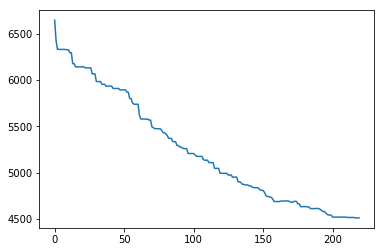

In [69]:
plt.plot(c_array)

In [66]:
cost_best

4589.298744781768

From above graph it can be seen that the best cost for simulated annealing is 4220.159960 and the best design it got is as follows.

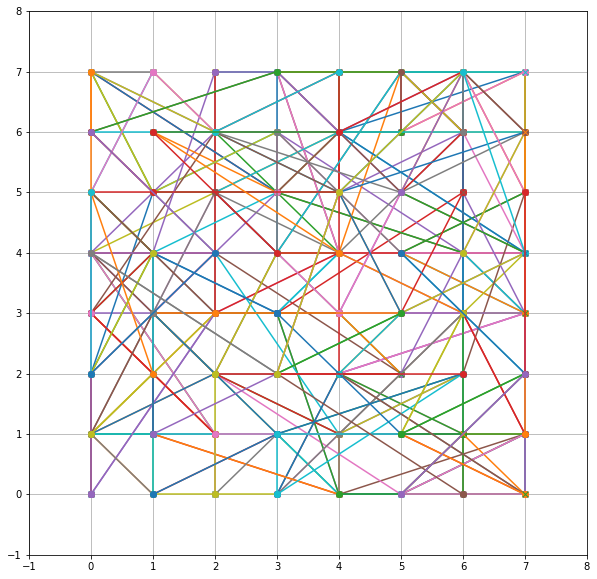

In [42]:
display_NOC(best_design)

# STAGE  and  Adjacency Matrix

Adjacency Matrix has been calculated and encoding has been done for core and link.
Link placement: adjacency matrix
Task placement: vector for task placement

In [43]:
def core_placement(design):
    core_matrix = np.zeros((64))
    for i in range(64):
        core_matrix[design[i].Id] = int(design[i].Position[0]*8+design[i].Position[1])
    core_matrix = core_matrix.reshape(1,64)    
    return core_matrix
       
def core_link(design):
    core_links = np.zeros((64,64))
    for i in range(64):
         core_links[i] = adjacency(design[i])
    core_links = core_links.reshape(1,4096)        
    return core_links

def adjacency(c):
    line=np.zeros(64)
    for n in c.Neighbours:
        adj = n[0]*8 +n[1]
        line[adj] = 1
    return line 

In [ ]:
random_d = random_NOC_generator()
random_d = change_design(new_design)
a = core_link_encode(new_design)
b = core_placement_encode(new_design)
a,b

In [44]:
def greedy_search(designs, costs, current,dataset):
    graph_current =create_graph(current)
    cost_current = cost_function(current, graph_current)
    while cost_current == 'invalid':
        current = random_NOC_generator()
        graph_current =create_graph(current)
        cost_current = cost_function(current, graph_current)
    dataset.append((current , cost_current))
    epoch = 0
    while epoch<25:
        nxt = randomly_change_design(current)
        g_nxt = create_graph(nxt)
        cost_nxt = cost_function(nxt,g_nxt)
        if cost_nxt != 'invalid':
            if cost_nxt< cost_current:
                l_map = core_placement(nxt)
                adj_matrix = core_link(nxt)
                line = np.append(l_map, adj_matrix)
                costs.append(cost_nxt)
                designs.append(line)
                #print("Better design was found")
                current = copy.deepcopy(nxt)
                cost_current = copy.deepcopy(cost_nxt)
                dataset.append((current , cost_current))
        epoch +=1
    return current

Simple hill climbing approach to accept all the good design and iterated 1000 times in order to find  through/optimal  design

In [49]:
def hill_climbing(current, regressor_model,database):
    c_place = core_placement(current)
    adj_matrix = core_link(current)
    line = np.append(c_place, adj_matrix)
    line = line.reshape(1,4160)
    current_cost = regressor_model.predict(line)
    epoch = 0
    while epoch<5000:
        nxt = randomly_change_design(current)
        c_place = core_placement(nxt)
        adj_matrix = core_link(nxt)
        line = np.append(c_place, adj_matrix)
        line = line.reshape(1,4160)
        nxt_cost = regressor_model.predict(line)
        if nxt_cost< current_cost:
            current_cost = nxt_cost
            current = nxt
        epoch +=1
    return current

Stage algorithm has been implemented

In [52]:
from sklearn.ensemble import RandomForestRegressor
def stage():
    curr_state = random_NOC_generator()
    design_db = []
    count =0
    curr_state = greedy_search(d_dataset , d_costs , curr_state,design_db)
    while count< 10:
        random_regr = RandomForestRegressor(max_depth=10, random_state=20,n_estimators=100)
        random_regr.fit(d_dataset, d_costs)
        curr_state = hill_climbing(random_NOC_generator(),random_regr,design_db)
        curr_state = greedy_search(d_dataset , d_costs , curr_state,design_db)
        count+=1
    return curr_state,design_db

In [53]:
d_dataset = []
d_costs = []
b_state , d = stage()

Not a valid design


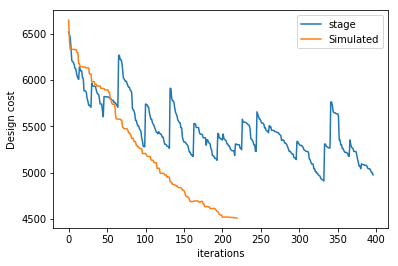

In [70]:
x=[]
[x.append(i[1]) for i in d]
plt.plot(x,label= 'stage')
plt.plot(c_array,label= 'Simulated')
plt.xlabel('iterations')
plt.ylabel('Design cost')
plt.legend()
plt.show()


In [76]:
traffic = np.loadtxt('traffic_complement.csv',delimiter=',')# Load Traffic file
traffic.shape        
# Base design Construction
for i in range(64):
    Core_design.append(core())
    Core_design[i].Traffic = traffic_allocation(traffic[i])
    Core_design[i].Id = i

In [77]:
best, cost_best,rec = simulated_annealing(random_NOC_generator())


Simulation starts


In [78]:
d_dataset1 = []
d_costs1 = []
b_design1,d1 = stage()

<function matplotlib.pyplot.show(*args, **kw)>

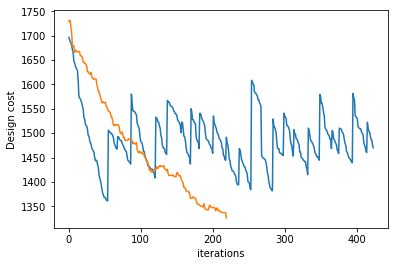

In [79]:
x=[]
[x.append(i[1]) for i in d1]
plt.plot(x)
plt.plot(rec)
plt.xlabel('iterations')
plt.ylabel('Design cost')
plt.show()

Simulation starts


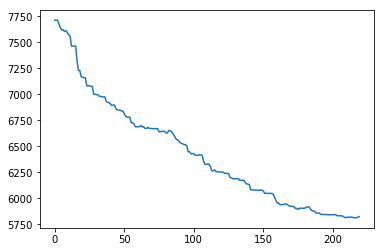

In [80]:
traffic = np.loadtxt('traffic_rand.csv',delimiter=',')# Load Traffic file
traffic.shape        
for i in range(64):
    Core_design.append(core())
    Core_design[i].Traffic = traffic_allocation(traffic[i])
    Core_design[i].Id = i
best, cost_best,records2 = simulated_annealing(random_NOC_generator())
plt.plot(records2)

Not a valid design


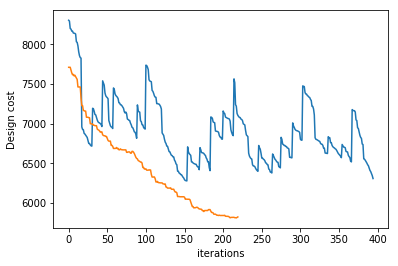

In [81]:
design_dataset2 = []
design_costs2 = []
b2,c2 = stage()
x=[]
[x.append(i[1]) for i in c2]
plt.plot(x)
plt.plot(records2)
plt.xlabel('iterations')
plt.ylabel('Design cost')

plt.show()

# Conclusion

In conclusion, following the result we can say that simulated annealing outperforms in terms of lowest cost however, Stage provides the steep deacrease in cost first but it does not go down after some point.